In [1]:
import numpy as np
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
PATH = '/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat'
data = loadmat(PATH)
data = data['amp_data']

# Question 1a

## Histogram 

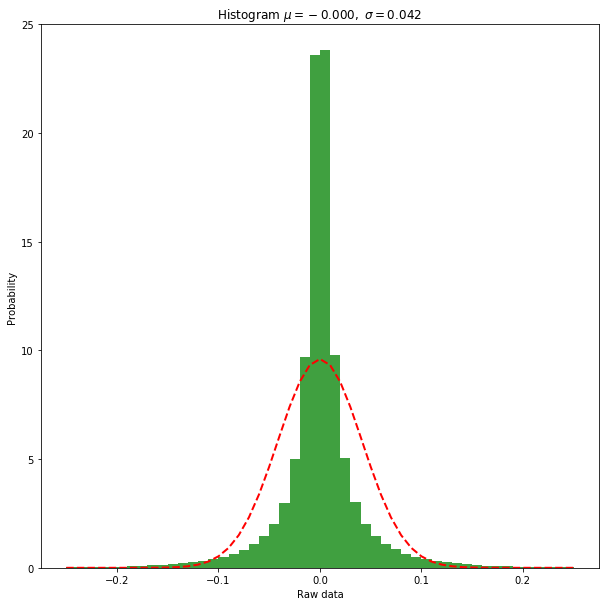

In [3]:
(mu, sigma) = norm.fit(data)
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(data, 50, normed=1, facecolor='g', alpha=0.75, range=[-.25, .25])
y = mlab.normpdf(bins, mu, sigma)
plt.xlabel('Raw data')
plt.ylabel('Probability')
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title(r'$\mathrm{Histogram}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

The data seems to come from a Normal Distribution centered around zero and a relatively small standard deviation. This is good since we are not required to apply transformations (centering, scaling) to the raw data in order to start modeling.

## Serie

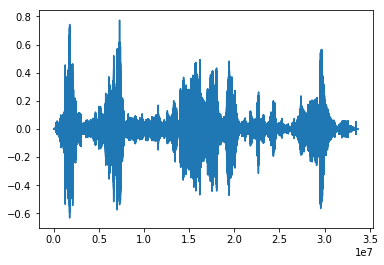

In [4]:
plt.plot(np.arange(data.shape[0]),data)
plt.show()

We can note the the observations are not independent of their order in what they appear. We can observe a strong local correlation among the observations. We need to shuffle the data.

# Question 1b

In [5]:
import math

def reshaping(data_input,col_dim):
    row_dim = data_input.shape[0] // col_dim
    temp = data[0:(col_dim*row_dim)]
    data_output = np.reshape(temp, (row_dim,col_dim))
    return(data_output)

def shuffling(data_input,seed):
    np.random.seed(seed)
    np.random.shuffle(data_input)
    return(data_input)

def splitting(data_input, percent):
    limit = math.floor(data_input.shape[0]*percent)
    first = data_input[:limit,]
    second = data_input[limit:data_input.shape[0],]
    return first,second

def splitting_targets(data_input,target_col):
    n = data_input.shape[0]
    x = data_input[:n,:(target_col-1)]
    y = data_input[:n,(target_col-1):target_col]
    return x,y

def partitioning(train,valid,test,target_col):
    x_train, y_train = splitting_targets(train,target_col)
    x_valid, y_valid = splitting_targets(valid,target_col)
    x_test, y_test = splitting_targets(test,target_col)
    del train,valid,test
    return x_train,y_train,x_valid,y_valid,x_test,y_test

In [6]:
def make_all(data,seed,percent,target_col):
    data = shuffling(data,seed)
    train,remaining = splitting(data,percent)
    valid, test = splitting(remaining,0.5)
    x_train,y_train,x_valid,y_valid,x_test,y_test = partitioning(train,valid,test,target_col)
    return x_train,y_train,x_valid,y_valid,x_test,y_test

In [7]:
data = reshaping(data,21)

In [8]:
x_train,y_train,x_valid,y_valid,x_test,y_test = make_all(data,seed=1570541,percent=0.7,target_col=21)

# Question 2a

## Generic function to create a linear and a polynomial (quartic) model for some particular observation

In [9]:
def make_models(row,degree):
    x_axis = np.arange(x_train[:1,].shape[1])/20
    x_obs = np.squeeze(x_train[(row-1):row],axis=0)
    y_obs = np.squeeze(y_train[(row-1):row],axis=0)
    # Scatter plot
    plt.figure(figsize=(10,10))
    plt.scatter(x_axis,x_obs)
    plt.show()
    # Linear model
    A = np.vstack([x_axis, np.ones(len(x_obs))]).T
    m, c = np.linalg.lstsq(A,x_obs)[0]
    # Quartic model
    A_poly = np.array([np.power(x_axis,i) for i in np.arange(degree+1)]).T
    solution = np.linalg.lstsq(A_poly,x_obs)[0]
    #Assign the predictions
    prediction_linear = m*1+c
    prediction_quartic = np.dot(np.ones((solution.shape[0],1)).T,solution)[0]
    #Plot the solutions
    plt.figure(figsize=(10,10))
    plt.plot(x_axis, x_obs, 'o', label='Original data', markersize=10)
    plt.plot(x_axis, m*x_axis + c, 'r', label='Linear model')
    plt.plot(x_axis, np.dot(A_poly,solution), 'g', label='Quartic model')
    plt.plot(1, y_obs, 'b*', label='Real value')
    plt.plot(1, prediction_linear, 'r*', label='Linear prediction')
    plt.plot(1, prediction_quartic, 'g*', label='Quartic prediction')
    plt.legend()
    plt.show()
    return prediction_linear, prediction_quartic

## Applying our function for some rows

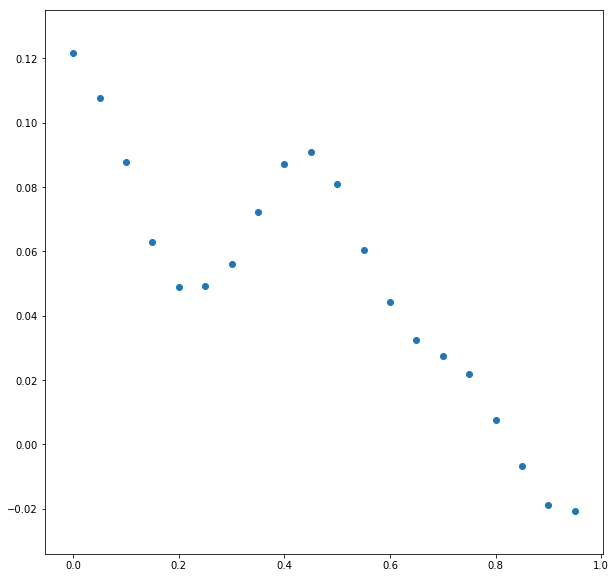

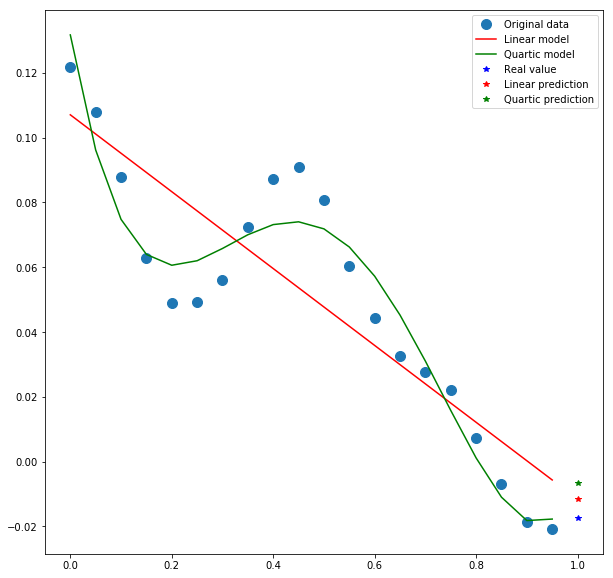

In [10]:
prediction_linear , prediction_quartic = make_models(1,4)

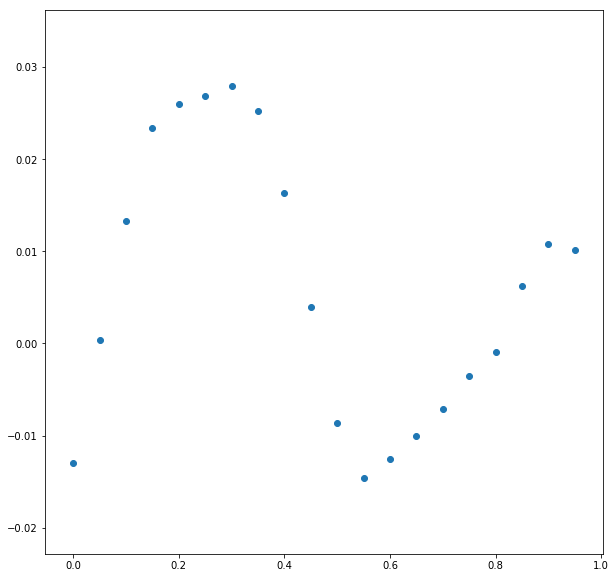

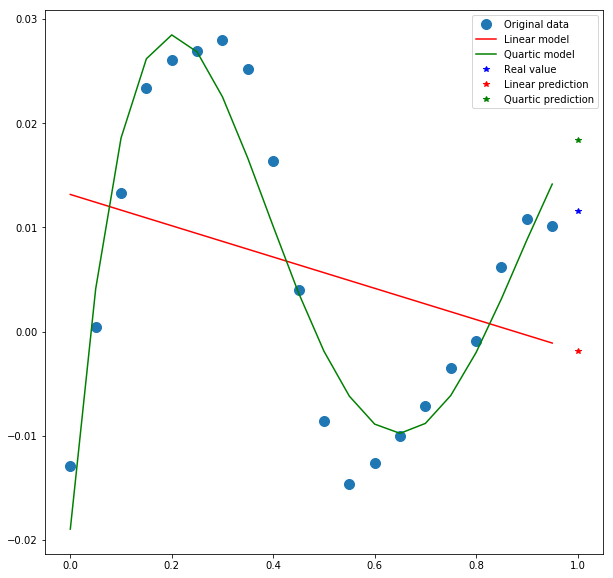

In [11]:
_ , _ = make_models(2,4)

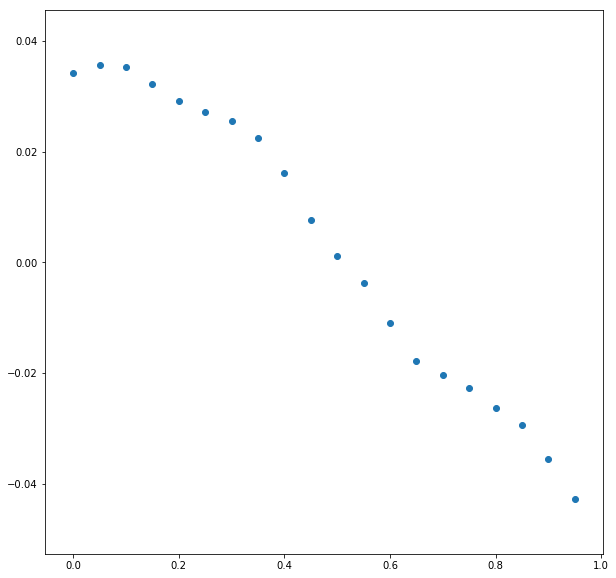

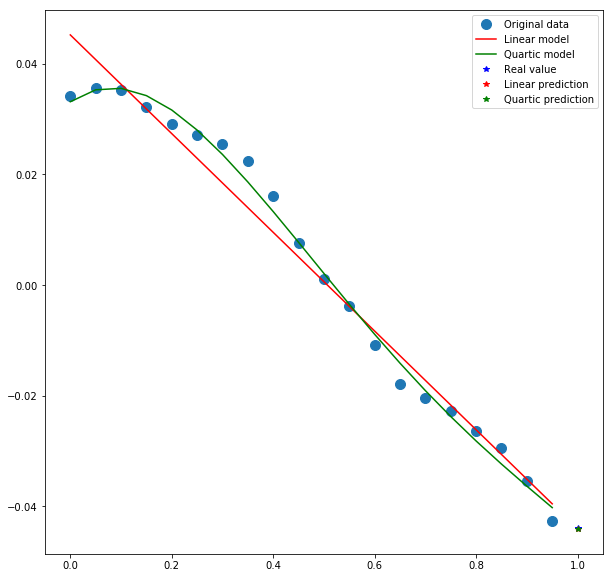

In [12]:
_ , _ = make_models(3,4)

# Question 2b

After observing the behavior of some observations in the previous plots, we can note that the nature of the data is not linear. If we take only the two most recent observations and fit a linear model, we are making a very local approximation so it's highly likely that the model perform better (at least, in training set) in contrast with a model of higher contexts, where given the non linear nature of the data, it's expected that a linear model is not going to perform well.

# Question 2c

Just by some visual guessing, it seems that a context length of $C=20$ and a $K=4$ could perform well. Given a large enough context length, we can make a enough good 4th order polynomial approximation that predicts well on unseen data. We would need to choose $K$ somehow objectively (by cross-validation, for example) but intuition suggest that lower values of $K$ such as $K=1$ or $K=2$ would underfit unseed data and greather values such as $K=5$ would overfit unseen data.

# Question 3a

The model's prediction for the next time step is given by $f(t=1) = \mathbf{w}^{T} \mathbf{\Phi}(t=1)$ 

Now, we know that the least squares closed-form solution for $\mathbf{w}$ is given by
$\mathbf{w} = \left[ \mathbf{\Phi}^{T} \mathbf{\Phi} \right]^{-1} \mathbf{\Phi}^{T} \mathbf{x}$, where we can define a matrix $\mathbf{A}$ to be $ \mathbf{A} = \left[ \mathbf{\Phi}^{T} \mathbf{\Phi} \right]^{-1} \mathbf{\Phi}^{T}$

Therefore, substituting $\mathbf{w}$ in the expression for $f(t=1)$ gives:

$f(t=1) = \mathbf{x}^{T} \mathbf{A}^{T} \mathbf{\Phi}(t=1)$ and since $\mathbf{\Phi}(t=1) = \mathbf{e}$ where $\mathbf{e}$ is the vector of ones of length $K$, we finally get:

$f(t=1) = \mathbf{x}^{T} \mathbf{v}$ where we have defined the vector $\mathbf{v} = \mathbf{A}^{T}\mathbf{e}$

# Question 3b1

In [13]:
def Phi(row,C,K):
    x = x_train[:,(20 - C):20]
    x_axis = np.arange(x_train[:1,].shape[1])/20
    x_axis = x_axis[:C,]
    x_obs = np.squeeze(x[(row-1):row,],axis=0)
    phi = np.array([np.power(x_axis,i) for i in np.arange(K+1)]).T
    return phi,x_obs

# Question 3b2

In [14]:
def make_vv(row,C,K):
    phi, x_obs = Phi(row,C,K)
    A = np.dot(np.linalg.inv(np.dot(phi.T,phi)),phi.T)
    return np.dot(A.T,np.ones(K+1)), x_obs

# Question 3b3

In [15]:
# Comparing with the linear model
v_test, x_obs = make_vv(row=1,C=20,K=1)
print(np.dot(v_test,x_obs))
print(prediction_linear)

-0.0115870425576
-0.0115870425576


In [16]:
# Comparing with the quartic model
v_test, x_obs = make_vv(row=1,C=20,K=4)
print(np.dot(v_test,x_obs))
print(prediction_quartic)

-0.00643870508218
-0.00643870508216


# Question 3c1

In [17]:
def mse(v,x,y):
    mse = np.sum(np.array([np.power(np.dot(v,x[i-1])-y[i-1],2) for i in np.arange(0,y.shape[0])]))/y.shape[0]
    return mse

def evaluating(input_data,input_targets,valid_data,valid_targets,C,K):
    x = input_data[:,(20 - C):20]
    y = np.squeeze(input_targets,axis=1)
    
    # Training step - Get v vector
    v , _ = make_vv(row=1,C=C,K=K)
    
    x_valid = valid_data[:,(20 - C):20]
    y_valid = np.squeeze(valid_targets,axis=1)
    
    mse_train = mse(v,x,y)
    mse_valid = mse(v,x_valid,y_valid)
    return mse_train, mse_valid

In [18]:
# Set C=15, K=4
mse_train, mse_valid = evaluating(x_train,y_train,x_valid,y_valid,C=15,K=4)
print(mse_train)
print(mse_valid)

0.0509476069329
0.0509713996823


In [19]:
# Set C=10, K=3
mse_train, mse_valid = evaluating(x_train,y_train,x_valid,y_valid,C=10,K=3)
print(mse_train)
print(mse_valid)

0.228355939068
0.228249040303


In [20]:
mse_train, mse_valid = evaluating(x_train,y_train,x_valid,y_valid,C=2,K=2)
print(mse_train)
print(mse_valid)

0.621772891754
0.613695535853


# Question 3c2

In [21]:
#results = [[c, k, evaluating(x_train,y_train,x_valid,y_valid,
#                                   C=c,K=k)] for c in np.arange(10,21) 
#                                            for k in np.arange(2,5)]

In [22]:
#results

In [23]:
# Evaluating in the test data
#evaluating(x_train,y_train,x_test,y_test,C=20,K=4)

# Question 4a

In [24]:
def mse(solution,x,y):
    mse = np.sum(np.power(np.dot(x,solution)-y,2))/y.shape[0]
    return mse

def evaluating(input_data,input_targets,valid_data,valid_targets,C):
    x = input_data[:,(20 - C):20]
    y = np.squeeze(input_targets,axis=1)
    
    A = np.dot(np.linalg.inv(np.dot(x.T,x)),x.T)
    solution = np.dot(A,y)
    
    x_valid = valid_data[:,(20 - C):20]
    y_valid = np.squeeze(valid_targets,axis=1)
    
    mse_train = mse(solution,x,y)
    mse_valid = mse(solution,x_valid,y_valid)
    return mse_train, mse_valid

In [25]:
results = [[c, evaluating(x_train,y_train,x_valid,y_valid,C=c)] for c in np.arange(1,21)]

In [26]:
results

[[1, (3.6672905030011095e-05, 3.6892202668197524e-05)],
 [2, (1.1610680191583648e-05, 1.1469989061895242e-05)],
 [3, (9.8873838402385247e-06, 9.5746924503934861e-06)],
 [4, (9.5292014266334054e-06, 9.1738548263624935e-06)],
 [5, (9.0880393460389426e-06, 8.7942287823907363e-06)],
 [6, (8.8989522854431298e-06, 8.6168371335934399e-06)],
 [7, (8.3724684986435161e-06, 8.0804501398581262e-06)],
 [8, (8.1347042411717756e-06, 7.8599447343280082e-06)],
 [9, (8.0586348617657224e-06, 7.8340497512795035e-06)],
 [10, (7.9461688118052885e-06, 7.7739234594756123e-06)],
 [11, (7.8738605231847008e-06, 7.7267793068007455e-06)],
 [12, (7.8186187092594953e-06, 7.651663124085577e-06)],
 [13, (7.7668676710819795e-06, 7.6123124744610935e-06)],
 [14, (7.7562958977528772e-06, 7.6202215019544328e-06)],
 [15, (7.74037997047101e-06, 7.6107576169557848e-06)],
 [16, (7.7323098932864994e-06, 7.5995948293173704e-06)],
 [17, (7.7145752063957447e-06, 7.5852492873762855e-06)],
 [18, (7.7134000847614856e-06, 7.5862046417

In [27]:
#Evaluating in the test data
evaluating(x_train,y_train,x_test,y_test,C=20)

(7.7102438418437494e-06, 8.0471901167956849e-06)

The context length $C=20$ is the one with lowest *MSE* on both the training and validation sets.
As now we have a simpler linear model, the context length parameter $C$ is our only complexity parameter. As long as we increase this parameter, we are getting better results on both sets of data. It is very likely that if we had longer context lengths, eventually we would observe a decrease on the performance on validation data. Nevertheless, with the value $C=20$ it seems we are not reaching that inflexion point.

# Question 4b

### Comparing previous results

# Question 4c

In [28]:
def res(solution,x,y):
    residuals = (np.dot(x,solution)-y)
    return residuals

def residuals(input_data,input_targets,valid_data,valid_targets,C):
    x = input_data[:,(20 - C):20]
    y = np.squeeze(input_targets,axis=1)
    
    A = np.dot(np.linalg.inv(np.dot(x.T,x)),x.T)
    solution = np.dot(A,y)
    
    x_valid = valid_data[:,(20 - C):20]
    y_valid = np.squeeze(valid_targets,axis=1)
    
    residuals_valid = res(solution,x_valid,y_valid)
    return residuals_valid

In [29]:
residuals_valid = residuals(x_train,y_train,x_test,y_test,C=19)

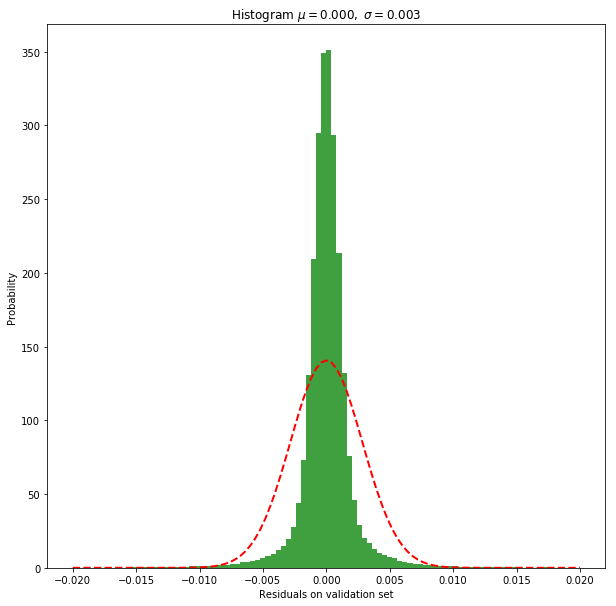

In [30]:
(mu, sigma) = norm.fit(residuals_valid)
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(residuals_valid, 100, normed=1, facecolor='g', alpha=0.75, range=[-.02, .02])
y = mlab.normpdf(bins, mu, sigma)
plt.xlabel('Residuals on validation set')
plt.ylabel('Probability')
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.title(r'$\mathrm{Histogram}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

Similary to the raw data plotted at the beggining, the residuals on validation set seems to follow a Normal Distribution centered around zero and a very small standard deviation. Since this distribution is obtained over the validation data, we can conclude that our system is performing well. We are obtaining a zero residual on average with small variability.